In [1]:
#This script is used to calculated f (use TES data fro example)
import numpy as np
import xarray as xr
from scipy.interpolate import griddata

C:\Users\jiang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#mask of crop grids
#2 deg#######
imai0=np.load('/change to your path/imai0_full.npy',allow_pickle=True)
y3d=np.arange(70,-60.1,-2.)
x3d=np.arange(-170,180.1,2.)
lon3s,lat3s=np.meshgrid(x3d, y3d)

imai_2degf=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        al=[imai0[0,y,x],imai0[1,y,x],imai0[2,y,x],imai0[3,y,x],imai0[4,y,x]]
        if np.count_nonzero(np.array(al)>0)>0:
            imai_2degf[y,x]=np.nanmax(al)

In [5]:
#add crop calendar data mask
wcu=xr.open_dataset('/change to your path/Wheat.crop.calendar.nc')
loncs,latcs=np.meshgrid(wcu.longitude[19::], wcu.latitude[39:300])#GCE
long,latg=np.meshgrid(wcu.longitude, wcu.latitude)#CCD
imog_nacf=np.load('/change to your path/cecl_gs_0.5_v3.npy',allow_pickle=True)     
#2deg
y1d=np.arange(70,-60.1,-2)
x1d=np.arange(-170,180.1,2)
lon2s,lat2s=np.meshgrid(x1d, y1d)
imog_nac2=np.zeros((2,66,176))*np.nan
imog_nac2[0,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[0,:,:].ravel(),(lon2s, lat2s) , method='nearest') #general growing season start  
imog_nac2[1,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[1,:,:].ravel(),(lon2s, lat2s) , method='nearest') #general growing season end

In [6]:
#NIRv data mask
#2002-2022 NIRv datasets
#grid 1 DEG
y1d=np.arange(70,-60.1,-1)
x1d=np.arange(-170,180.1,1)
lon1s,lat1s=np.meshgrid(x1d, y1d)
nirvf=np.load('/change to your path/nir_full_1deg.npy',allow_pickle=True)
nirvf5=np.zeros((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        nirvf5[yr,pdt,:,:] = griddata((lon1s[0:130,0:350].ravel(),lat1s[0:130,0:350].ravel()), nirvf[yr,pdt,::-1,:].ravel(),(lon3s, lat3s) , method='nearest')   
#get rid of non crop & -1 grids
crop_m3=np.where(imai_2degf<2)#better rerun the array readin code
nirvf_m5=np.ones((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        mk4=np.where(nirvf5[yr,pdt,:,:]<0)
        i3=nirvf5[yr,pdt,:,:]
        i3[mk4]=np.nan
        i3[crop_m3]=np.nan
        nirvf_m5[yr,pdt,:,:]=i3
        
#grow season
nirvf_mean=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        sog_na=imog_nac2[0,y,x]
        eog_na=imog_nac2[1,y,x]
        if np.isnan(sog_na)==False and np.isnan(eog_na)==False and imai_2degf[y,x]>=2:
            sogr_na=int(round(sog_na)/5.)#if %5==0, then need to -1
            eogr_na=int(round(eog_na)/5.)
            if sogr_na%5==0:
                sogr_na=sogr_na-1
            if eogr_na%5==0:
                eogr_na=eogr_na-1
            if sogr_na<eogr_na:
                nirl=np.nanmean(nirvf_m5[1:18,sogr_na:eogr_na+1,y,x],axis=0)
                nirvf_mean[y,x]=np.nanmean(nirl)
            if sogr_na>eogr_na:
                nirli=np.append(nirvf_m5[1:18,sogr_na::,y,x],nirvf_m5[2:19,0:eogr_na+1,y,x],axis=1)
                nirl=np.nanmean(nirli,axis=0)
                nirvf_mean[y,x]=np.nanmean(nirl)

C:\Users\jiang\AppData\Local\Temp\ipykernel_27372\1290898588.py:37: RuntimeWarning: Mean of empty slice
  nirl=np.nanmean(nirvf_m5[1:18,sogr_na:eogr_na+1,y,x],axis=0)
C:\Users\jiang\AppData\Local\Temp\ipykernel_27372\1290898588.py:38: RuntimeWarning: Mean of empty slice
  nirvf_mean[y,x]=np.nanmean(nirl)
C:\Users\jiang\AppData\Local\Temp\ipykernel_27372\1290898588.py:41: RuntimeWarning: Mean of empty slice
  nirl=np.nanmean(nirli,axis=0)
C:\Users\jiang\AppData\Local\Temp\ipykernel_27372\1290898588.py:42: RuntimeWarning: Mean of empty slice
  nirvf_mean[y,x]=np.nanmean(nirl)


In [3]:
#2-deg coordination from TES
te1=xr.open_dataset('/change to your path/TES-Aura_L2-HDO-Nadir_2006-04_v006_Litev01.00.nc')
xi = np.arange(te1.Longitude.min(), te1.Longitude.max(), 2.)
yi = np.arange(te1.Latitude.max(), te1.Latitude.min(), -2.)#-81.5-81.8

In [4]:
#read in TES data:2004-2015
ddf_an=np.load('/change to your path/ddf_an.npy',allow_pickle=True)
qtf_an=np.load('/change to your path/qtf_an.npy',allow_pickle=True)
prf_an=np.load('/change to your path/prf_an.npy',allow_pickle=True)
lof_an=np.load('/change to your path/lof_an.npy',allow_pickle=True)
laf_an=np.load('/change to your path/laf_an.npy',allow_pickle=True)

In [9]:
#surface condition
dt_sf=np.load('/change to your path/gnip_dt_suf_mean.npy',allow_pickle=True)
#free atmosphere (619-510hPa average)
dt_tp=np.load('/change to your path/dt_65top.npy',allow_pickle=True)
qt_tp=np.load('/change to your path/qt_65top.npy',allow_pickle=True)

In [10]:
#take April for example
#pentad index: 18-23
dt_am6=np.zeros((73,65,175))*np.nan 
for y in range(65):
    for x in range(175):
        sog_na=imog_nac2[0,y,x]
        eog_na=imog_nac2[1,y,x]
        if np.isnan(nirvf_mean[y,x])==False and np.isnan(sog_na)==False and np.isnan(eog_na)==False and imai_2degf[y,x]>=2:#strict cropland selection 
            lac=yi[y+5]
            loc=xi[x+4]
            dist=[]
            dtsf=dt_sf[y,x]
            if np.isnan(dtsf)==True:
                dtsf=np.nanmean(dt_sf[y-5:y+5,x-5:x+5])
            for t in range(18,24):
                qfr=[]
                dfr=[]
                qfrt=[]
                dfrt=[]
                for yr in range(1,8):#climatology: using year 2005-2011 with less missing values
                    q1=qtf_an[yr][t]
                    d1=ddf_an[yr][t]
                    p1=prf_an[yr][t]
                    lo1=lof_an[yr][t]
                    la1=laf_an[yr][t]
                    if len(q1)!=0:
                        for i in range(len(q1)):
                            if lo1[i]>=loc and lo1[i]<=loc+2.0 and la1[i]<=lac and la1[i]>=lac-2.0 and p1[i]<=910 and p1[i]>=500:#908-348
                                qfr=np.append(qfr,q1[i])
                                dfr=np.append(dfr,d1[i])
                if len(qfr)!=0:
                    qfr2=qfr
                    qfrtv=qt_tp[y,x]
                    dfrtv=dt_tp[y,x]
                    if np.isnan(qfrtv)==True:
                        qfrtv=np.nanmean(qt_tp[y-5:y+5,x-5:x+5])
                    if np.isnan(dfrtv)==True:
                        dfrtv=np.nanmean(dt_tp[y-5:y+5,x-5:x+5])

                    dfr2=np.delete(dfr,dfr>0)
                    qfr2=np.delete(qfr2,dfr>0)
                    
                    if len(dfr2)>0:
                        dreg=qfrtv*(dfrtv-dtsf)*(1/(qfr2))+dtsf
                        dt_am6[t,y,x]=np.count_nonzero(dfr2>=dreg)/len(dfr2)

In [11]:
#make the plot
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

C:\Users\jiang\AppData\Local\Temp\ipykernel_27372\2121106297.py:7: RuntimeWarning: Mean of empty slice
  shade=m.pcolor(lon3s,lat3s,np.nanmean(dt_am6[18:24,:,:],axis=0)*100,vmin=0,vmax=100,cmap=plt.cm.jet)


Text(0.0, 1.0, 'f April_Clim')

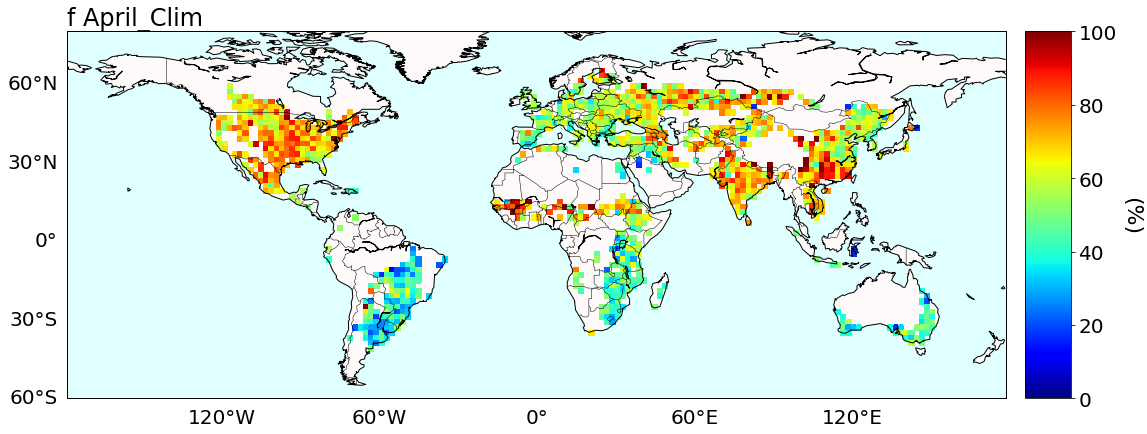

In [12]:
fig=plt.figure(figsize=(18,20),linewidth=2)
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-179,llcrnrlat=-60,urcrnrlon=179,urcrnrlat=80, epsg=4326)
m.drawmapboundary(fill_color='lightcyan')
m.fillcontinents(color='snow',lake_color='lightcyan')
#tmask5=maskoceans(lons,lats,np.nanmean(acea_aprilm,axis=0),inlands=True)
shade=m.pcolor(lon3s,lat3s,np.nanmean(dt_am6[18:24,:,:],axis=0)*100,vmin=0,vmax=100,cmap=plt.cm.jet)
cbar=m.colorbar(shade)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('(%)',fontsize=22,va='bottom',rotation=-90)
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=20)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=20)
m.drawcoastlines()
m.drawcountries()
ax1.set_title('f April_Clim', loc='left',fontsize=24)